In [1]:
from PIL import Image, ImageDraw, ImageFont, ImageColor
import os
import csv

def calculate_text_size(text, font):
    # calculate text size based on font properties
    ascent, descent = font.getmetrics()
    text_width = font.getmask(text).getbbox()[2]
    text_height = ascent + descent
    return text_width, text_height

def get_brightness(color):
    # Calculate brightness of a color (grayscale value) for the text
    r, g, b = ImageColor.getrgb(color)
    return (r * 299 + g * 587 + b * 114) / 1000 


def visualize_image(filename, csv_filename):
        # Open image
        image_path = filename
        img = Image.open(image_path)
        draw = ImageDraw.Draw(img)

        # Read bounding box information from CSV file
        if os.path.getsize(csv_filename) > 0:
            with open(csv_filename, 'r') as csvfile:
                csvreader = csv.reader(csvfile)
                #next(csvreader)  # Skip header row
                for row in csvreader:
                    if row:
                        xmin, ymin, xmax, ymax = map(int, row[0:4])
                        class_name = row[4]
        
                        # Define colors for different classes
                        class_colors = {
                            'danger': 'yellow',
                            'interdiction': 'purple',
                            'obligation': 'blue',
                            'stop': 'magenta',
                            'ceder': 'cyan',
                            'frouge': 'red',
                            'forange': 'orange',
                            'fvert': 'green'
                        }
        
                         # Define brightness threshold for determining text color
                        brightness_threshold = 150  
        
                        # Get bounding box color
                        box_color = class_colors.get(class_name, 'white') #white is the de
        
                        # Determine text color based on brightness of box color
                        text_color = 'black' if get_brightness(box_color) > brightness_threshold else 'white'
        
                        # Draw bounding box
                        draw.rectangle([(xmin, ymin), (xmax, ymax)], outline=box_color)
        
                        # Define font and size
                        font_size = 30 # Adjust the font size here
                        font = ImageFont.truetype("arial.ttf", font_size)
        
                        # Get text size
                        text_width, text_height = calculate_text_size(class_name, font)
        
                        # Draw filled rectangle as background for class name
                        draw.rectangle([(xmin, ymin - text_height), (xmin + text_width, ymin)], fill=box_color)
        
                        # Draw class name text on top of the filled rectangle
                        draw.text((xmin, ymin - text_height), class_name, fill=text_color, font=font)
        return img

In [2]:
from skimage import io, util,color
import os
import numpy as np
from skimage.feature import daisy
import matplotlib.pyplot as plt

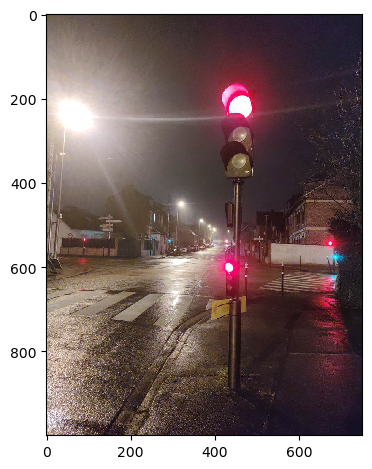

In [3]:
img = io.imread('train/images/0001.jpg')
io.imshow(img)

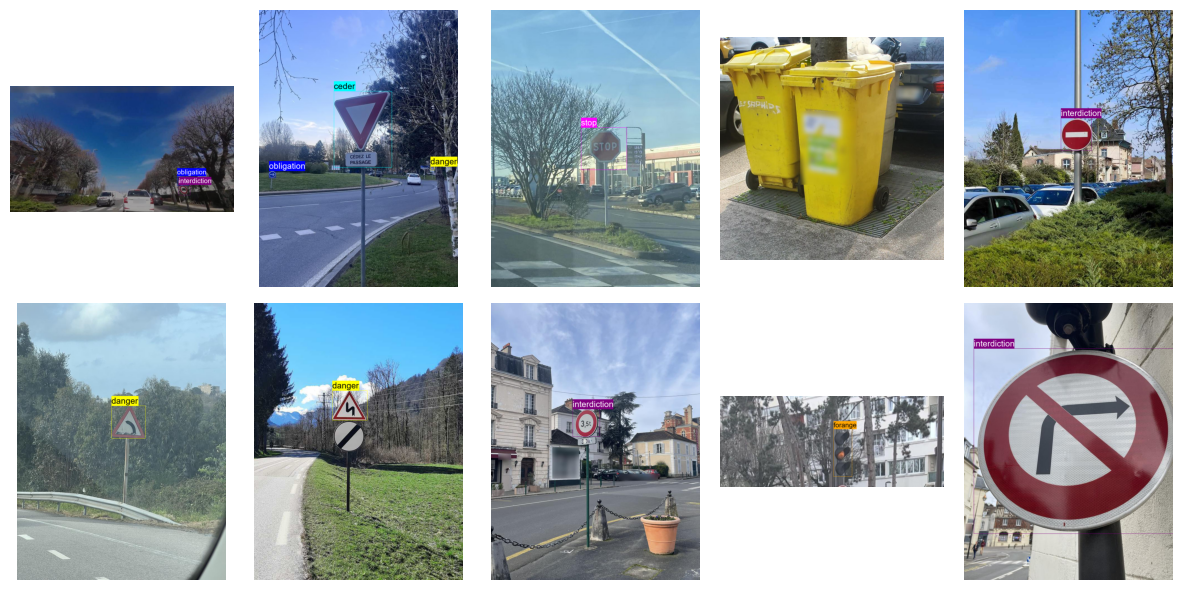

In [4]:
# Affiche au hasard des images positives de l'ensemble d'apprentissage
import random

fig, axs = plt.subplots(2, 5, figsize=(12, 6))
for ax in axs.ravel():
    images_dir = os.path.join("train", "images")
    labels_dir = os.path.join("train", "labels")
    image_name = random.choice(os.listdir(images_dir))
    image_path = os.path.join(images_dir, image_name)
    csv_path = os.path.join(labels_dir, image_name[:-4] + ".csv")   
    # Call visualize_image function to modify the image
    image_to_display = visualize_image(image_path, csv_path)
    
    # Display the modified image
    ax.imshow(image_to_display)
    ax.axis('off')
        
plt.tight_layout()
plt.show()

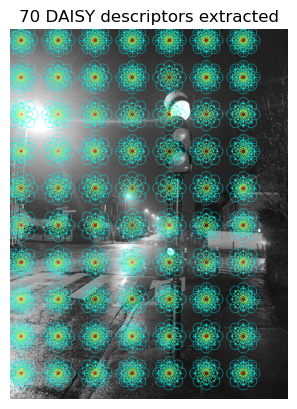

In [5]:

img = io.imread('train/images/0001.jpg',as_gray=True)
descs, descs_img = daisy(img,
                          step=100, radius=30, rings=3, histograms=8,
                          orientations=8, visualize=True)

# Plot the DAISY features
fig, ax = plt.subplots()
ax.axis("off")
ax.imshow(descs_img, cmap='gray')
descs_num = descs.shape[0] * descs.shape[1]
ax.set_title(f"{descs_num} DAISY descriptors extracted")
plt.show()

In [6]:

image_dir = 'train/images2/'

# List all image files in the directory
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

# Initialize a list to hold all descriptors
all_descriptors = []

for image_file in image_files:
    # Load the image as grayscale
    img = io.imread(os.path.join(image_dir, image_file), as_gray=True)
    
    # Compute DAISY features
    descs, descs_img = daisy(img, step=100, radius=30, rings=3, histograms=7, orientations=7, visualize=True)
    
    # Flatten the descriptors to a two-dimensional array and add to the list
    all_descriptors.append(descs.reshape(-1, descs.shape[2]))

# Concatenate all descriptors into a single matrix
descriptor_matrix = np.vstack(all_descriptors)

print(descriptor_matrix.shape)


(11642, 154)


In [7]:
from sklearn.cluster import KMeans

n_clusters = 10  # You can adjust this number based on your specific needs

# Initialize and fit KMeans algorithm
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(descriptor_matrix)

# The cluster centers are our visual words
visual_words = kmeans.cluster_centers_

C:\Users\Grzadziel Bartlomiej\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


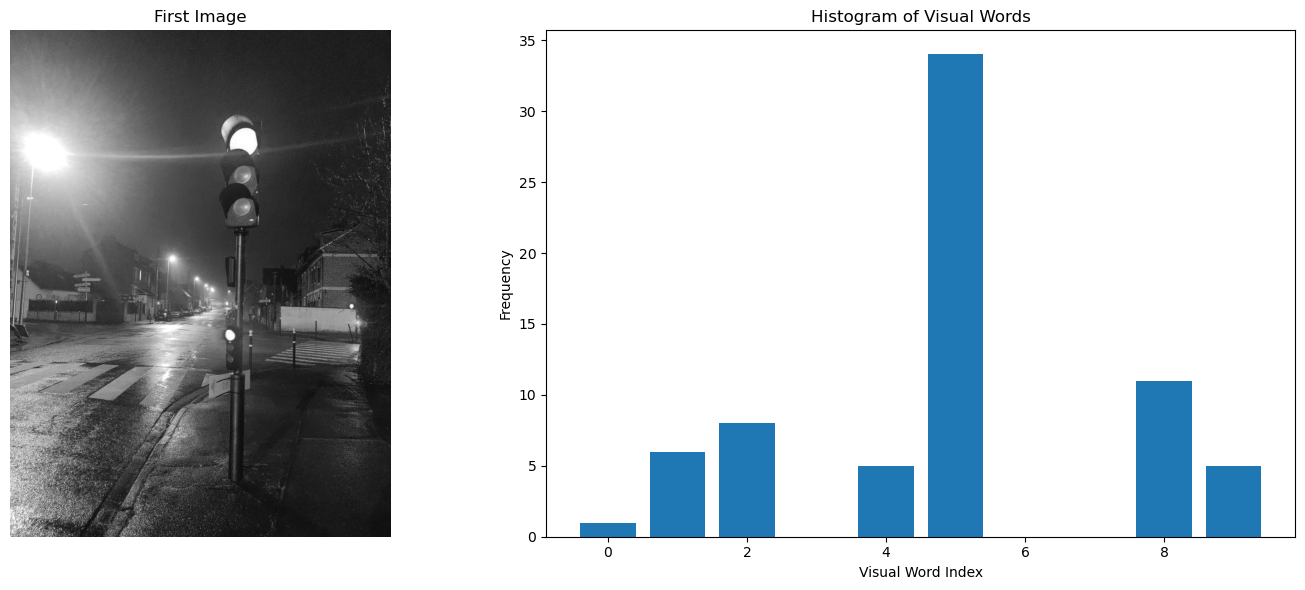

In [8]:
import matplotlib.pyplot as plt
from skimage import io
from skimage.feature import daisy
from sklearn.metrics import pairwise_distances_argmin_min
import numpy as np
import os
from sklearn.cluster import KMeans

# Load the image as grayscale
image_dir = 'train/images2/'
first_image_path = os.path.join(image_dir, image_files[0])
first_image = io.imread(first_image_path, as_gray=True)

# Compute DAISY features for the first image
descs, descs_img = daisy(first_image, step=100, radius=30, rings=3, histograms=7, orientations=7, visualize=True)

# Assume 'visual_words' from KMeans is available
# Assign descriptors to the nearest visual words (cluster centers)
closest_centers = pairwise_distances_argmin_min(descs.reshape(-1, descs.shape[2]), visual_words)[0]

# Count the occurrences of each visual word in the first image
visual_word_histogram = np.bincount(closest_centers, minlength=n_clusters)

# Plot the first image and its histogram side-by-side
plt.figure(figsize=(15, 6))

# Subplot for the image
plt.subplot(1, 2, 1)
plt.imshow(first_image, cmap='gray')
plt.title('First Image')
plt.axis('off')  # Turn off axis numbers and ticks

# Subplot for the histogram
plt.subplot(1, 2, 2)
plt.bar(range(n_clusters), visual_word_histogram, align='center')
plt.xlabel('Visual Word Index')
plt.ylabel('Frequency')
plt.title('Histogram of Visual Words')

plt.tight_layout()
plt.show()


Computed distances for 10/164 images
Computed distances for 20/164 images
Computed distances for 30/164 images
Computed distances for 40/164 images
Computed distances for 50/164 images
Computed distances for 60/164 images
Computed distances for 70/164 images
Computed distances for 80/164 images
Computed distances for 90/164 images
Computed distances for 100/164 images
Computed distances for 110/164 images
Computed distances for 120/164 images
Computed distances for 130/164 images
Computed distances for 140/164 images
Computed distances for 150/164 images
Computed distances for 160/164 images
Top 5 similar images:
0158.jpg
0138.jpg
0007.jpg
0168.jpg
0121.jpg


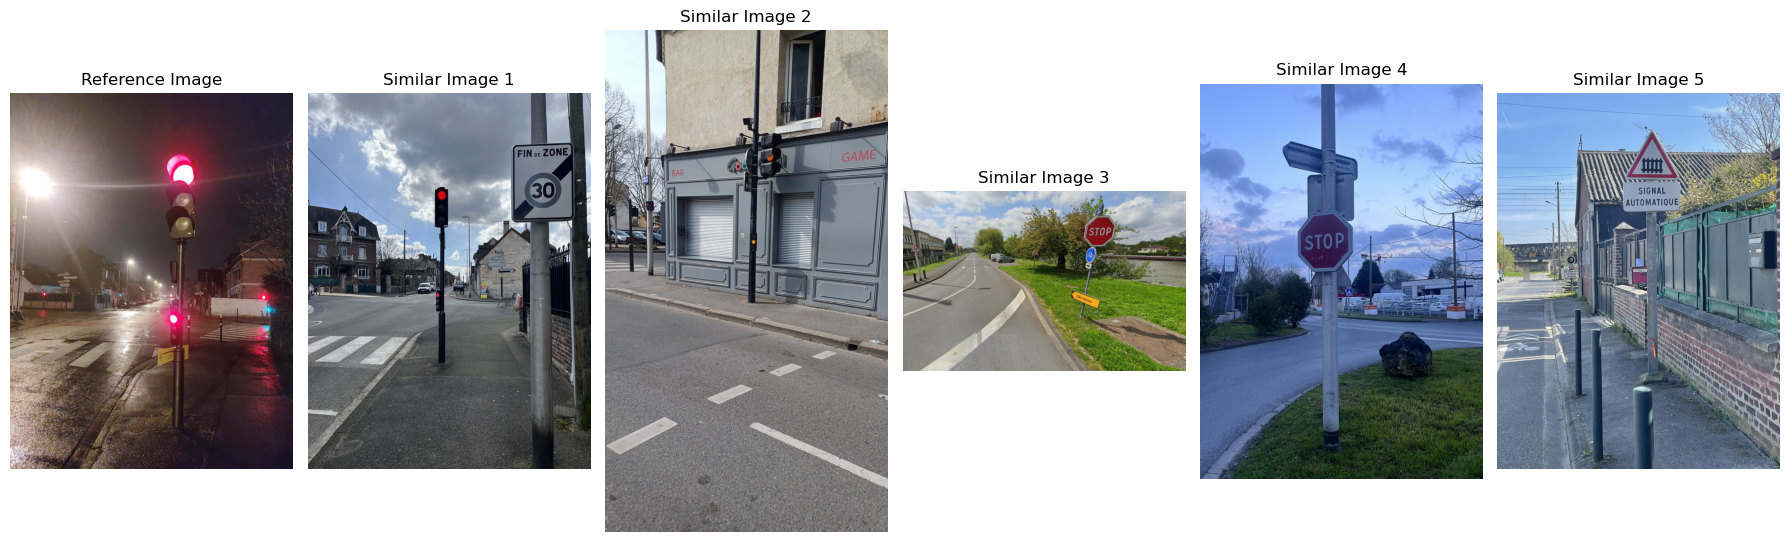

In [9]:

def compute_histogram(image_path):
    # Load the image in color
    image = io.imread(image_path)
    # Convert the image to grayscale
    image_gray = color.rgb2gray(image)
    
    # Compute DAISY features
    descs, descs_img = daisy(image_gray, step=100, radius=30, rings=3, histograms=7, orientations=7, visualize=True)
    
    # Ensure the descriptor dimensions match the visual words
    descs_reshaped = descs.reshape(-1, descs.shape[2])
    if descs_reshaped.shape[1] != visual_words.shape[1]:
        raise ValueError(f"Incompatible dimension: DAISY descriptors {descs_reshaped.shape[1]} vs Visual words {visual_words.shape[1]}")
    
    # Assign descriptors to the nearest visual words (cluster centers)
    closest_centers = pairwise_distances_argmin_min(descs_reshaped, visual_words)[0]
    
    # Count the occurrences of each visual word
    histogram = np.bincount(closest_centers, minlength=n_clusters)
    
    return histogram

def find_similar_images(reference_image_path, num_similar=5):
    # Compute the histogram for the reference image
    reference_histogram = compute_histogram(reference_image_path)
    
    # Compute histograms for all images in the directory and compare
    distances = []
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(image_dir, image_file)
        if image_path == reference_image_path:
            continue  # Skip the reference image
        histogram = compute_histogram(image_path)
        distance = euclidean_distances(reference_histogram.reshape(1, -1), histogram.reshape(1, -1))[0][0]
        distances.append((distance, image_file))
        
        if (i + 1) % 10 == 0:  # Print progress every 10 images
            print(f"Computed distances for {i + 1}/{len(image_files)} images")
    
    # Sort by distance and get the top 'num_similar' images
    distances.sort()
    similar_images = [image_file for _, image_file in distances[:num_similar]]
    
    return similar_images

# Example usage:
reference_image_path = 'train/images2/0001.jpg'  # Replace with the path to your reference image
similar_images = find_similar_images(reference_image_path)

print("Top 5 similar images:")
for img in similar_images:
    print(img)

# Plotting the reference and similar images
plt.figure(figsize=(18, 6))

# Plot the reference image
reference_image = io.imread(reference_image_path)
plt.subplot(1, 6, 1)
plt.imshow(reference_image)
plt.title('Reference Image')
plt.axis('off')

# Plot the similar images
for i, img_file in enumerate(similar_images):
    img_path = os.path.join(image_dir, img_file)
    img = io.imread(img_path)
    
    plt.subplot(1, 6, i + 2)
    plt.imshow(img)
    plt.title(f'Similar Image {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
from joblib import Parallel, delayed
from sklearn.metrics import pairwise_distances_argmin_min, euclidean_distances

def compute_histogram(image_path):
    # Load the image in color
    image = io.imread(image_path)
    # Convert the image to grayscale
    image_gray = color.rgb2gray(image)
    
    # Compute DAISY features
    descs, descs_img = daisy(image_gray, step=100, radius=30, rings=3, histograms=7, orientations=7, visualize=True)
    
    # Ensure the descriptor dimensions match the visual words
    descs_reshaped = descs.reshape(-1, descs.shape[2])
    if descs_reshaped.shape[1] != visual_words.shape[1]:
        raise ValueError(f"Incompatible dimension: DAISY descriptors {descs_reshaped.shape[1]} vs Visual words {visual_words.shape[1]}")
    
    # Assign descriptors to the nearest visual words (cluster centers)
    closest_centers = pairwise_distances_argmin_min(descs_reshaped, visual_words)[0]
    
    # Count the occurrences of each visual word
    histogram = np.bincount(closest_centers, minlength=n_clusters)
    
    return histogram

def compute_distance(image_file, reference_histogram):
    image_path = os.path.join(image_dir, image_file)
    histogram = compute_histogram(image_path)
    distance = euclidean_distances(reference_histogram.reshape(1, -1), histogram.reshape(1, -1))[0][0]
    return (distance, image_file)

def find_similar_images(reference_image_path, num_similar=5, n_jobs=-1):
    # Compute the histogram for the reference image
    reference_histogram = compute_histogram(reference_image_path)
    for i in enumerate(image_files):
        if (i + 1) % 10 == 0:  # Print progress every 10 images
            print(f"Computed distances for {i + 1}/{len(image_files)} images")
    
    # Use parallel computation for distance calculation
    distances = Parallel(n_jobs=n_jobs)(
        delayed(compute_distance)(image_file, reference_histogram)
        for image_file in image_files if os.path.join(image_dir, image_file) != reference_image_path
    )
    
    # Print progress
    for i, _ in enumerate(distances):
        if (i + 1) % 10 == 0:  # Print progress every 10 images
            print(f"Computed distances for {i + 1}/{len(image_files) - 1} images")
    
    # Sort by distance and get the top 'num_similar' images
    distances.sort()
    similar_images = [image_file for _, image_file in distances[:num_similar]]
    
    return similar_images

def plot_similar_images(reference_image_path, similar_images):
    # Plotting the reference and similar images
    plt.figure(figsize=(18, 6))

    # Plot the reference image
    reference_image = io.imread(reference_image_path)
    plt.subplot(1, 6, 1)
    plt.imshow(reference_image)
    plt.title('Reference Image')
    plt.axis('off')

    # Plot the similar images
    for i, img_file in enumerate(similar_images):
        img_path = os.path.join(image_dir, img_file)
        img = io.imread(img_path)
        
        plt.subplot(1, 6, i + 2)
        plt.imshow(img)
        plt.title(f'Similar Image {i + 1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def find_and_plot_similar_images(reference_image_path, num_similar=5, n_jobs=-1):
    similar_images = find_similar_images(reference_image_path, num_similar, n_jobs)
    
    print("Top 5 similar images:")
    for img in similar_images:
        print(img)
    
    plot_similar_images(reference_image_path, similar_images)




Computed distances for 10/163 images
Computed distances for 20/163 images
Computed distances for 30/163 images
Computed distances for 40/163 images
Computed distances for 50/163 images
Computed distances for 60/163 images
Computed distances for 70/163 images
Computed distances for 80/163 images
Computed distances for 90/163 images
Computed distances for 100/163 images
Computed distances for 110/163 images
Computed distances for 120/163 images
Computed distances for 130/163 images
Computed distances for 140/163 images
Computed distances for 150/163 images
Computed distances for 160/163 images
Top 5 similar images:
0186.jpg
0041.jpg
0171.jpg
0010.jpg
0107.jpg


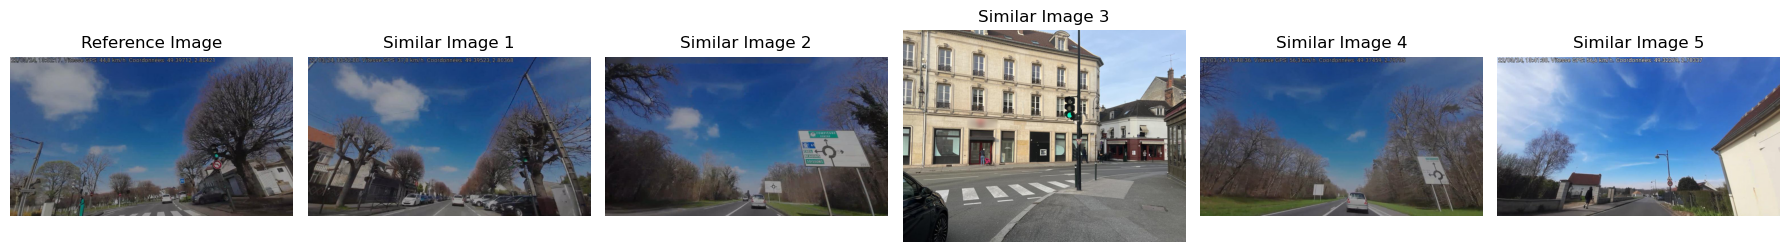

In [12]:
reference_image_path = 'train/images2/0003.jpg'  # Replace with the path to your reference image
find_and_plot_similar_images(reference_image_path)

In [ ]:
reference_image_path = 'train/images2/0005.jpg'  # Replace with the path to your reference image
find_and_plot_similar_images(reference_image_path)